# Cohort Analysis, Customer Segmentation and Market Basket Analysis

This project aims to perform cohort analysis, customer segmentation and market basket analysis using a dataset which contains info for transactions.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the csv file and properlly parsing the date
online = pd.read_csv('online.csv', parse_dates = ['InvoiceDate'])

# Displaying first rows of the dataframe
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [3]:
print('The dataframe has {} rows and {} columns'.format(online.shape[0], online.shape[1]))
print('The dataframe has {} null values'.format(online.isnull().sum().sum()))

The dataframe has 70864 rows and 9 columns
The dataframe has 0 null values


### Cohort analysis

Cohort analysis generates mutually exclusive segments of clients measured through time. It allows to compare product/client metrics in the lifecycle. I will display cohort analysis data using pivot table and heatmaps. The first column of the table shows the cohort (in this case the month of the first purchase) while the other columns show a specific month after the first purchase. Finally, the values in the table are the customized metrics we are interested in.

In [4]:
# Formatting Invoice date
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'].dt.strftime('%Y-%m-%d'))

# Grouping by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDate'] 

# Creating a new column with first invoice for each customer
online['CohortDay'] = grouping.transform('min')

# Viewing top 5 rows
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CohortDay
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,2011-04-11
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,2011-09-12
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,2011-07-14
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2011-11-23
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,2011-02-25


In [5]:
# Creating year - month column
online['InvoiceMonth'] = pd.to_datetime(online['InvoiceDate'].dt.strftime('%Y-%m-01'))

# Creating a new column with first invoice for each customer
online['CohortMonth'] = online.groupby(['CustomerID'])['InvoiceMonth'].transform('min')

# Calculating difference in year
year_diff = online['InvoiceMonth'].dt.year - online['CohortMonth'].dt.year

# Calculating difference in month
month_diff = online['InvoiceMonth'].dt.month - online['CohortMonth'].dt.month

# Creating a column with total difference in months between first invoice and all the other invoices
online['CohortIndex'] = year_diff * 12 + month_diff + 1 

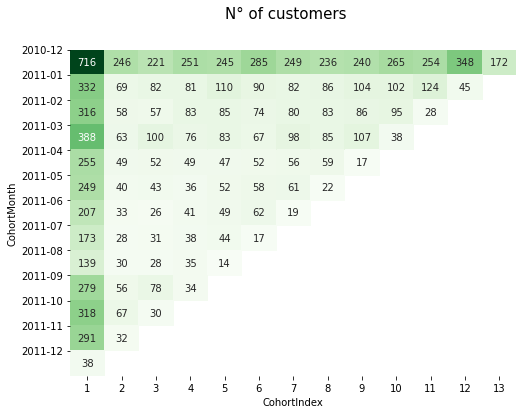

In [6]:
# Defining a function that outputs a cohort table
def get_cohort_table(df, index, cohort, target_col, aggfunc):    
    cohort_df = df.groupby([index, cohort])[target_col].agg(aggfunc).reset_index()
    cohort_table = cohort_df.pivot_table(index = index, columns = cohort, values = target_col)
    return cohort_table

# Defining a function that outputs a heatmap 
def get_heatmap(cohort_table, cmap, fmt, title):
    plt.subplots(figsize = (8, 6))
    sns.heatmap(cohort_table, cmap = cmap, annot = True, cbar = False, fmt = fmt)
    plt.yticks([i for i in range(len(cohort_table.index))], labels = cohort_table.index.strftime('%Y-%m'))
    plt.suptitle(title, fontsize = 15)

# Generating a cohort table for number of customers
n_customers = get_cohort_table(df = online, index = 'CohortMonth', cohort = 'CohortIndex', target_col = 'CustomerID', aggfunc ='nunique')

# Plotting a heatmap
get_heatmap(n_customers, cmap = 'Greens', fmt = '.0f', title = 'N° of customers')

As shown above the number of customers that purchase at the initial month (first invoice) is way higher than those that purchase in the following months. The heatmap clearly helps to visualize trends through time.

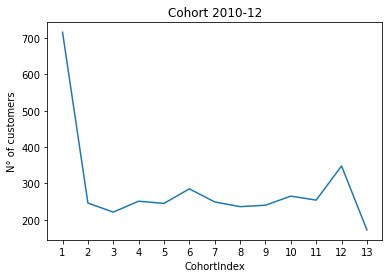

In [7]:
# Plotting trend for the oldest cohort
sns.lineplot(data = n_customers.T, x = 'CohortIndex', y = '2010-12-01')
plt.title('Cohort 2010-12')
plt.xticks([i for i in range(1,14)])
plt.ylabel("N° of customers");


The cohort table is useful to visualize specific trends too, as shown above. Even the oldest cohort underwent a pronounced reduction in numbers of customers. Although calculating the number of customers at each specific month is useful to evaluate numbers on absolute terms, a more interesting KPI would be retention, which is the ratio between the number of purchasers at a specific month and initial purchasers. The cohort table allows to easily visualize these numbers

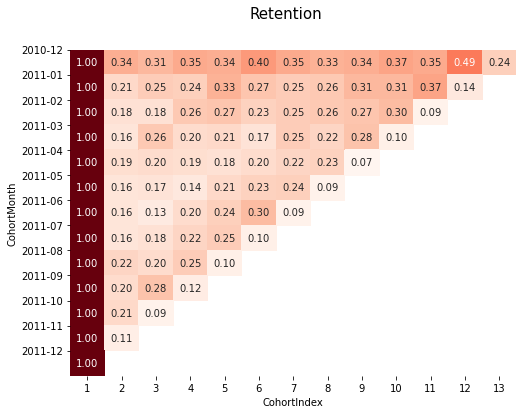

In [8]:
# Isolating the first column of the cohort table
cohort_sizes = n_customers.iloc[:, 0]

# Calculating retention
retention = n_customers.divide(cohort_sizes, axis=0).round(2)

# Plotting heatmap
get_heatmap(retention, cmap = 'Reds', fmt = '.2f', title = 'Retention')

Clearly, retention is set to 1 in the first column. This KPI gives a better understanding of trends in customers numbers in relation to the first purchase.

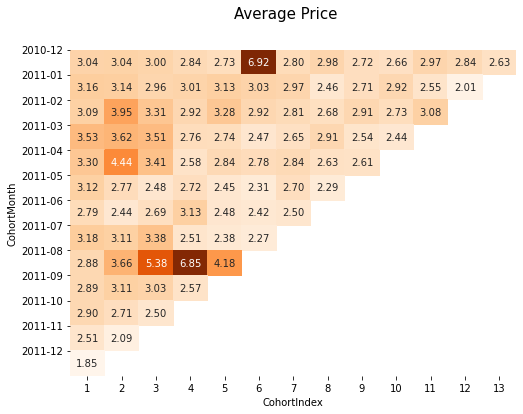

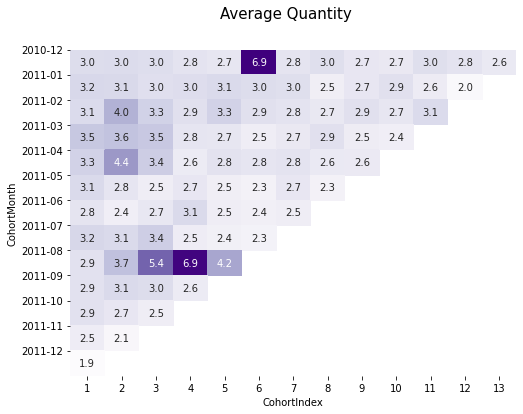

In [9]:
# Generating cohort tables for average price and quantity
average_price = get_cohort_table(df = online, index = 'CohortMonth', cohort = 'CohortIndex', target_col = 'UnitPrice', aggfunc = 'mean')
average_quantity = get_cohort_table(df = online, index = 'CohortMonth', cohort = 'CohortIndex', target_col = 'Quantity', aggfunc = 'mean')

# Plotting heatmaps
get_heatmap(average_price, cmap = 'Oranges', fmt = '.2f', title = 'Average Price')
get_heatmap(average_price, cmap = 'Purples', fmt = '.1f', title = 'Average Quantity')

As shown above cohort table and heatmaps are an useful tool for monitoring KPIs and metrics over time. They are also quite versatile and can be easily designed by reshaping the dataframe and defining few functions.

### Customer Segmentation

Customer segmentation is useful to identify groups of customers that can then be used for several purposes such as target marketing. I will segment clients based on three metrics:

- Recency --> how recent a purchase is
- Frequency --> number of purchases over a certain period
- Monetary Value --> money spent over a certain period

I will define a time interval of 1 year as the period I am interested in analyzing. Therefore the dataframe has to be filtered accordingly.

In [10]:
# Printing the time interval available in the dataframe
print('First invoice date: {}'.format(online.InvoiceDate.min()))
print('Lat invoice date: {}'.format(online.InvoiceDate.max()))

First invoice date: 2010-12-01 00:00:00
Lat invoice date: 2011-12-09 00:00:00


It looks like the dataframe records cover a little more than 1 year. I will filter out the extra rows.

In [11]:
# Setting InvoiceDate as index to manipulate the dataframe
online.set_index('InvoiceDate', inplace = True)

# Filtering the dataframe to cover exactly one year invoices
online_1_year = online.loc['2010-12-10':, :].reset_index()

From the dataframe we can see that we already have columns for calculating recency and frequency but we lack monetary value. I will generate this column multiplying quantity by price.

In [12]:
online_1_year['TotalSum'] = online_1_year.Quantity * online_1_year.UnitPrice

In order to calculate recency (time from last purchase) we need to set a date in respect of which calculate how recent a purchase is. I will simply set this date to the day after the most recent date in invoice date.

In [13]:
# Setting the reference date
reference_date = online_1_year.InvoiceDate.max() + timedelta(days = 1)

I am now ready to calculate recency, frequency and monetary value by customer.

In [14]:
# Calculate Recency, Frequency and Monetary value for each customer 
data_rfm = online_1_year.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (reference_date - x.max()).days,
                                                      'InvoiceNo': 'count',
                                                      'TotalSum': 'sum'})

# Rename the columns 
data_rfm.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
data_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


### Quantile segmentation

In this type of segmentation I will segment customers based on quantiles, which is a good starting point. In this case, thresholds are decided based on data distributions. A label will be applied to each segment, with higher values assigned to better results. Note that for frequency and monetary value the higher the value the better the result, but for recency the lower the value the better the result since we want more active customers with less time gap between purchases.

In [15]:
# Create labels for recency frequency and monetary value
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)


# Assign these labels to four equal percentile groups for each column 
r_groups = pd.qcut(data_rfm['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(data_rfm['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(data_rfm['MonetaryValue'], q=4, labels=m_labels)

# Adding new columns to the dataframe 
data_rfm = data_rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

I can now calculate the RFM score which is the sum of individual score for recency, frequency and monetary value.

In [16]:
# Adding the RFM_Score column
data_rfm['RFM_Score'] = data_rfm[['R','F','M']].sum(axis=1)

# Displaying the updated dataframe
data_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CustomerID,,,,,,,
12747,3,25,948.70,4,4,4,12
12748,1,888,7046.16,4,4,4,12
12749,4,37,813.45,4,4,4,12
12820,4,17,268.02,4,3,3,10
12822,71,9,146.15,2,2,3,7


The RFM score returns the overall performance based on the three metrics. It is also useful to add a column that identifies a specific segment as the concatenation of the scores assigned for each single metric. This way we could also explore segments that, for example, performed well in 2 out of 3 metrics.

In [17]:
# Adding a new column that identifies segments based on individual scores
data_rfm['RFM_Segment'] = data_rfm[['R', 'F', 'M']].astype(str).sum(axis = 1).astype(int)

# Counting the number of segment based on the new column
data_rfm.groupby('RFM_Segment').size().sort_values(ascending = False)[:10]

RFM_Segment
444    372
111    345
211    169
344    156
233    129
222    128
333    120
122    117
311    114
433    113
dtype: int64

As we can see, the best performing segment (444) is the most common one, follwed by the least performing segment (111). Although this labeling could be helpful for targeting specific segments in relation to certain metric values, assigning easy to interpret labels to segments is a key task in business related communication. I will then segment the RFM score to highlight 3 different levels of performance.

In [18]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
data_rfm['RFM_Level'] = data_rfm.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
data_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment,RFM_Level
CustomerID,,,,,,,,,
12747,3,25,948.70,4,4,4,12,444,Top
12748,1,888,7046.16,4,4,4,12,444,Top
12749,4,37,813.45,4,4,4,12,444,Top
12820,4,17,268.02,4,3,3,10,433,Top
12822,71,9,146.15,2,2,3,7,223,Middle


I can now calculate statistics for the defined segments.

In [19]:
# Calculate average values for each RFM_Level and returning a size of each segment 
rfm_level_agg = data_rfm.groupby('RFM_Level').agg({'Recency': 'mean',
                                                   'Frequency': 'mean',
                                                   'MonetaryValue': ['mean', 'count']
                                                   }).round(1)

# Displaying the aggregated dataset
rfm_level_agg

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         180.8       3.2          52.7  1075
Middle       73.9      10.7         202.9  1547
Top          20.3      47.1         959.7  1021

The identified segments seem to be well separated and numerically balanced and could therefore be used as a valid scheme for customers classification.

### Unsupervised learning segmentation

Another approach is to perform unsupervised learning in order to detect segments. I will use Kmeans which, given the number of clusters to find in the data, segments data accordingly.
In order to perform KMeans clustering, data need to be normally distrbuted and scaled. Let's first explore data distribution.

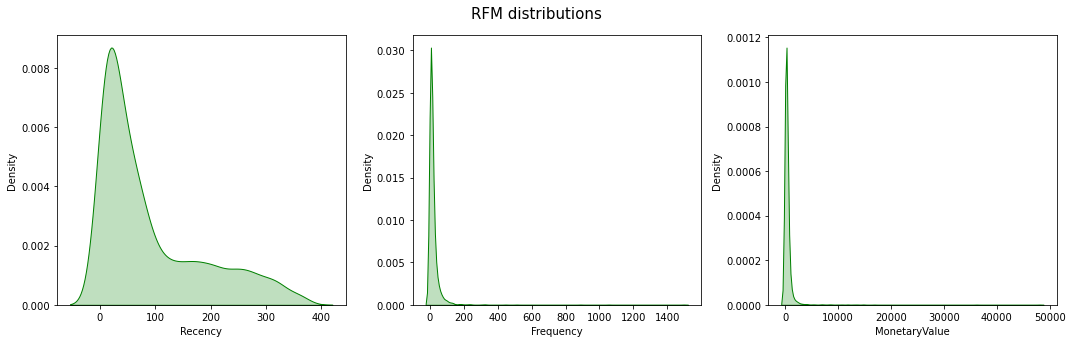

In [20]:
# Subsetting the dataframe
data_rfm_sub = data_rfm[['Recency', 'Frequency', 'MonetaryValue']]

# Plotting distributions
fig, axs = plt.subplots(1, 3, figsize = (15, 4.5))
for i, ax in zip(data_rfm_sub.columns, axs.flatten()):
    sns.kdeplot(data_rfm_sub[i], shade = True, ax = ax, color = 'g')
    plt.tight_layout()
plt.suptitle('RFM distributions', y = 1.05, fontsize = 15)
plt.show();

Since variables are skewed, transformation is needed to remove skewness. I will try to unskew them with a logaritmic transformation and a Box-Cox transformation and compare the results.

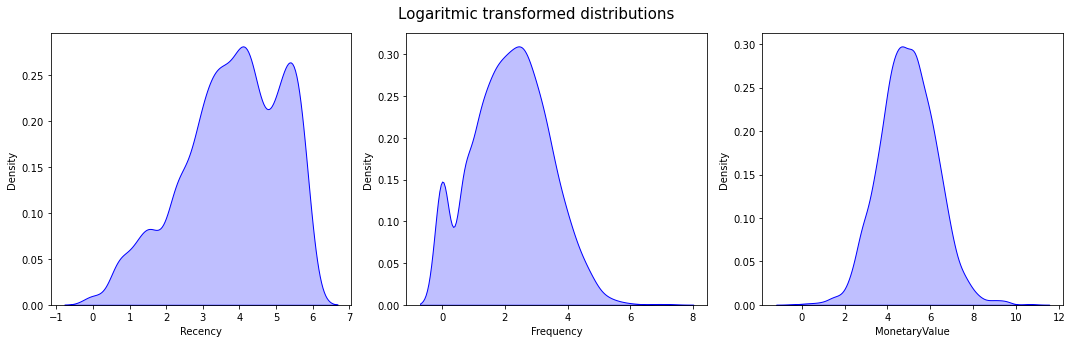

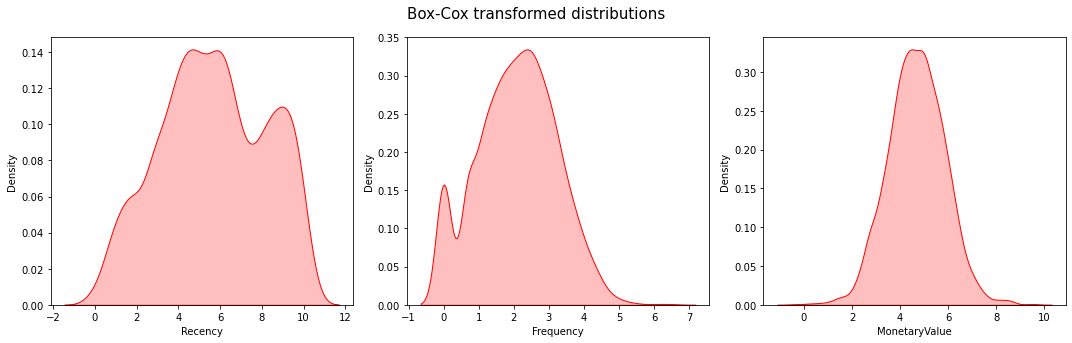

In [21]:
# Importing function from library
from scipy.stats import boxcox

# Defining a function that outputs the Box-Cox transformed dataframe
def box_cox_func(x):
    return boxcox(x)[0]

# Defining transformed dataframes
data_rfm_boxcox = data_rfm_sub.apply(box_cox_func, axis = 0)
data_rfm_log = np.log(data_rfm_sub)

# Dysplayng the transformed distributions
fig, axs = plt.subplots(1, 3, figsize = (15, 4.5))
for i, ax in zip(data_rfm_log.columns, axs.flatten()):
    sns.kdeplot(data_rfm_log[i], shade = True, ax = ax, color = 'b')
    plt.tight_layout()
plt.suptitle('Logaritmic transformed distributions', fontsize = 15, y = 1.05)
plt.show();

fig, axs = plt.subplots(1, 3, figsize = (15, 4.5))
for i, ax in zip(data_rfm_boxcox.columns, axs.flatten()):
    sns.kdeplot(data_rfm_boxcox[i], shade = True, ax = ax, color = 'r')
    plt.tight_layout()
plt.suptitle('Box-Cox transformed distributions', fontsize = 15, y = 1.05)
plt.show();

Both transformations are able to unskew the dataframe, but although the result looks comparable for frequency and monetary value, Box-Cox transformation seems to perform slightly better in relation to recency. I will then choose the latter to transform data.

Before running the algorithm it is worth evaluating the appropriate number of clusters since it is a parameter that needs to be set. To do so I will use the elbow rule which compares the inertia (a measure of data aggregation) of models trained with different number of clusters.

In [22]:
# Importing library
from sklearn.cluster import KMeans

# Building a dictionary with n° of clusters and inertia
inertia = {}
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=52)
    kmeans.fit(data_rfm_boxcox)
    inertia[k] = kmeans.inertia_

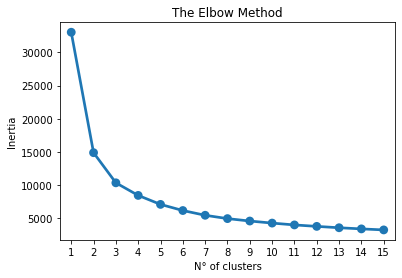

In [23]:
# Plotting inertia values for each key in the dictionary
sns.pointplot(x=list(inertia.keys()), y=list(inertia.values()))
plt.title('The Elbow Method')
plt.xlabel('N° of clusters')
plt.ylabel('Inertia');

It looks like 3 or 4 clusters are suggested by the elbow method. I can then proceed with scaling, unskewing and fitting the model.

In [24]:
# Importing class
from sklearn.preprocessing import StandardScaler

# Initialize a standard scaler and fit it
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_rfm_boxcox)

# Creating a pandas DataFrame
df_scaled = pd.DataFrame(data=df_scaled, index=data_rfm_boxcox.index, columns=data_rfm_boxcox.columns)

In [25]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=52) 

# Fit KMeans on the normalized data set
kmeans.fit(df_scaled)

# Create a DataFrame by adding a new cluster label column
df_k3 = data_rfm.assign(Cluster=kmeans.labels_)

# Group the data by cluster
rfm_kmeans = df_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'MonetaryValue': ['mean', 'count']
                                             }).round(1)
# Displaying aggregation
rfm_kmeans

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          19.4      47.0         972.1  1028
1         175.8       3.0          51.8  1078
2          78.1      10.9         192.1  1537

It looks like KMeans does a good job too, plus the identified segments are not very different from the ones detected with quantile segmentation. It is also possible to estimate the impact of values found with the segmentation in respect to the entire population.

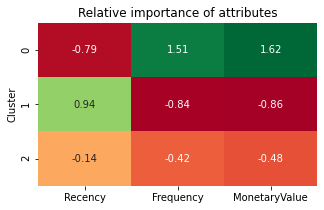

In [26]:
# Calculating average RFM values for each cluster
cluster_avg = df_k3.groupby(['Cluster'])[['Recency','Frequency','MonetaryValue']].mean() 

# Calculate average RFM values for the total population
population_avg = data_rfm[['Recency','Frequency','MonetaryValue']].mean()

# Calculating relative importance
relative_imp = cluster_avg/population_avg - 1

# Plotting a heatmap of relative importance
plt.figure(figsize=(5, 3))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', cbar = False);

We can see that, for example, cluster 0 (which is characterized by best performing metrics), shows frequency and monetary value well above the average population.

### Market Basket Analysis

Market Basket Analysis (MBA) allows to identify products that are frequently purchased together, hence providing recommendations or suggesting what items would be the best choice for cross-selling. The main goal of MBA is to discover association rules of the type "if item A is purchased, then item B is purchased too". Often the number of these association rules is quite high, so the challange is to identify few significant ones for the business. To calculate them I will use Apriori algorithm which is based on the assumption that a subset of frequent items is frequent too. 

Before extracting association rules, the column with the description of items needs some preprocessing:

In [27]:
# Lowercasing and eliminating spaces
online['Description'] = online.Description.str.lower().str.strip()

Also, the dataset needs to be reshaped and grouped by number of invoice so that items purchased with a single invoice are aggregated together.

In [28]:
# Grouping the dataframe by number of invoice and aggregating items
online_grouped = online.groupby('InvoiceNo')['Description'].agg(lambda x : ','.join(x)).reset_index()

# Generating a list of list requested as imput for the Apriori algorithm
transactions = list(online_grouped.Description.str.split(','))

# Importing libraries
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Initializing the encoder that will perform onehotencoding of transactions
encoder = TransactionEncoder()

# Onehotencoding transactions
onehot = encoder.fit_transform(transactions)

# Generating a dataframe
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot = onehot.iloc[:, 1:]

# Displaying first rows
onehot.head()

,1 hanger,back door,baroque,billboard fonts design,birthday card,breakfast in bed,chocolate spots,chocolate spots,doughnuts,front door,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Let's have a look to items with higher support which is the relative frequency of an item.

In [29]:
onehot.mean().sort_values(ascending = False)[:5]

white hanging heart t-light holder    0.027349
regency cakestand 3 tier              0.024535
assorted colour bird ornament         0.020999
jumbo bag red retrospot               0.019916
party bunting                         0.017319
dtype: float64

Unfortunately even the highest value of support is quite low, meaning it is infrequent. Let's apply Apriori algorithm and association rules extraction anyway.

In [30]:
# Applying Apriori algorithm
frequent_itemsets = apriori(onehot, use_colnames = True, min_support = 0.004, max_len = 2)

# Extracting association rule
association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.001)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Unfortunately, all the items show low support hence calculating association rules does not output anything. I will however calculate some metrics built on support for the 2 items with higher support. More specifically I will calculate the following:
- LIFT (if higher than 1, it indicates that two items are more likely bought together than individually)
- ZHANG (it outputs a value that ranges between -1 and 1 indicating complete dissociation and complete association between two items respectively)

In [31]:
# Calculating metrics to get lift
support_A = onehot['white hanging heart t-light holder'].mean()
support_B = onehot['regency cakestand 3 tier'].mean()
support_A_B = np.logical_and(onehot['white hanging heart t-light holder'], onehot['regency cakestand 3 tier']).mean()
lift = support_A_B/(support_A*support_B)

# Printing lift
print('The lift for the two highest support items is {:.2f}'.format(lift))

The lift for the two highest support items is 1.72


Although they are not often purchased given the low support, the lift value suggests that these 2 items are purchased together.

In [32]:
# Defining a function to ease Zhang value calculation
def zhang(col_A, col_B, df):
    support_A = df[col_A].mean()
    support_B = df[col_B].mean()
    support_A_B = np.logical_and(df[col_A], df[col_B]).mean()
    numerator = support_A_B - support_A*support_B
    denominator = max(support_A_B*(1-support_A), support_A*(support_B-support_A_B))
    return round(numerator/denominator, 2)

# Printing Zhang value
print('The Zhang value for the two highest support items is {}'.format(zhang('white hanging heart t-light holder',
                                                                             'regency cakestand 3 tier', onehot)))

The Zhang value for the two highest support items is 0.43


The Zhang value confirms that there is an association between the two items.

## Conclusion

In this project I leveraged python capabilities to deal with marketing analytics, builduing pivot tables and heatmaps for cohort analysis, segmenting customers using both variables distributions and unsupervised learning as well as applying market basket analysis to gather insights about items sold.